In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
import pandas as pd
import torch.distributions as distributions
from tqdm import trange

# Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, learning_rate=0.01, gamma=0.90):
        super(PolicyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.gamma = gamma

    def forward(self, state):
        return self.model(state)

    def predict(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        return self.forward(state)

    def update(self, states, actions, rewards, next_states):
        self.optimizer.zero_grad()

        # Forward pass for current and next states
        current_q_values = self.forward(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.forward(next_states).max(1)[0].detach()

        # Compute expected Q values using the Bellman equation
        target_q_values = rewards + self.gamma * next_q_values  # discount factor gamma = 0.99

        # Calculate loss using mean squared error
        loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))

        # Backpropagation and optimization
        loss.backward()
        self.optimizer.step()

        # # return loss
        # self.optimizer.zero_grad()
        # probs = self.forward(states)
        # log_probs = torch.log(self.forward(states))
        # loss = -(log_probs*rewards).mean()
        # loss.backward()
        # self.optimizer.step()

        return loss


# Define the Agent
class Agent:
    def __init__(self, name, environment, id, epsilon=0.5):
        self.name = name
        self.id = id
        self.social_network = environment
        self.state_dim = 3
        # self.action_dim = 2
        self.action_dim = 6 # considering that we have 5 Agents and we want one of the actions to just not interact at all.
        self.create_characteristics()
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim)
        self.epsilon = epsilon  # Exploration parameter
        self.reward_history = []  # To store the reward history for this agent

    def get_state(self):
        self.update_wellbeing()
        avg_connection_strength = self.total_weight / max(1, self.degree)
        state = [self.introversion, self.well_being, avg_connection_strength]
        return state

    # def select_partner(self):
    #     # Strategically select partner based on connection strength
    #     edges = list(self.social_network.network.edges(self.name, data=True))
    #     if not edges:
    #         return None  # In case there are no edges
    #     # Choose the partner with the strongest connection

    #     selected_edge = max(edges, key=lambda x: x[2]['weight'])
    #     return (selected_edge[0], selected_edge[1])


    # def select_partner(self):
    #   edges = list(self.social_network.network.edges(self.name, data=True))
    #   if not edges:
    #       return None  # In case there are no edges

    #   # Random selection weighted by connection strength
    #   total_weight = sum(data['weight'] for _, _, data in edges)
    #   if total_weight > 0:
    #       weights = [data['weight'] / total_weight for _, _, data in edges]
    #       selected_edge = random.choices(edges, weights=weights, k=1)[0]
    #   else:
    #       # If no weights are non-zero, select randomly
    #       selected_edge = random.choice(edges)

    #   return (selected_edge[0], selected_edge[1]) # Return the partner node

    # def select_partner(self):
    #   edges = list(self.social_network.network.edges(self.name))
    #   if not edges:
    #       return None
    #   return random.choice(edges)[0], random.choice(edges)[1]  # Randomly select an interaction partner


    def action(self):
      state = self.get_state()
      action_prob = self.policy_net.predict(state) # These are the probabilities for interaction with Agent i, no interaction 
      print(type(action_prob), action_prob[self.id], self.id) # this is just to check whether we have the actual right action dimensionprint(action_prob)
      # Choosing between exploration and exploitation
      if np.random.rand() < self.epsilon:
        action = np.random.choice(self.action_dim) # exploring what happens when you interact with an agent
      else:
          action = 1 
    #   # Sampling an action from the probability distribution
    #     action_prob[self.id] = 0.0
    #     print(action_prob)
    #     action_dist = distributions.Categorical(action_prob) # Look into this more deeply, change it potentially
    #     print(action_dist)
    #     action = action_dist.sample().item() # this is taking one of the actions and performing it
        
      if action == 0: # this is for the case when there is no action at all. 
          pass
      else:
        # interaction_partner = self.select_partner()
        interaction_partner = f"Agent_{action-1}"
        if interaction_partner != self.name:
        # LLM will play in here in determining the quality of the conversation
          quality_conversation = random.uniform(0,1) # random quality conversation
          self.social_network.update_connection((self.name, interaction_partner), quality_conversation)

      old_state = state
      next_state = self.get_state()
      self.update_wellbeing()
      reward = self.well_being # Adding a little bit of gaussian noise here. # this is a place to be augmented as well

      self.reward_history.append(reward) # Storing the reward for this state

      return old_state, action, next_state, reward

    #   state = self.get_state()
    #   action_prob = self.policy_net.predict(state)

    #   # Exploration-exploitation strategy: ε-greedy
    #   if np.random.rand() < self.epsilon:
    #       action = np.random.choice(self.action_dim)
    #   else:
    #       # Sample action from the probability distribution
    #       action_dist = distributions.Categorical(action_prob)
    #       action = action_dist.sample().item()

    #   if action == 0:
    #       interaction_partner = self.select_partner()
    #       if interaction_partner:
    #           quality_conversation = random.uniform(0, 1)  # Random quality conversation
    #           self.social_network.update_connection(interaction_partner, quality_conversation)

    #   old_state = state
    #   next_state = self.get_state()
    #   reward = self.well_being
    #   self.reward_history.append(reward)  # Store the reward for this step
    #   return old_state, action, next_state, reward

    # def update_wellbeing(self):
    #     self.degree = 0
    #     self.total_weight = 0
    #     for u, v in self.social_network.network.edges(self.name):
    #         self.total_weight += self.social_network.network[u][v]['weight']
    #         if self.social_network.network[u][v]['weight'] != 0.0:
    #           self.degree += 1
    #     self.sociality = self.total_weight / max(1, self.degree)
    #     # self.sociality = 1/(1 + np.exp(-self.total_weight)) 

    #     # self.well_being = (1 - self.introversion) * self.sociality + self.introversion * self.degree
    #     x = np.linspace(-10, 10, 100) 
    #     self.well_being = ((self.introversion) * self.sociality + self.introversion * max(1,self.degree))* (1/(1+np.exp(-x)))

    def update_wellbeing(self):
      self.degree = self.social_network.network.degree(self.name)
      self.total_weight = sum(self.social_network.network[self.name][v]['weight'] for v in self.social_network.network[self.name])
      self.sociality = self.total_weight / max(1, self.degree)
      centrality = nx.closeness_centrality(self.social_network.network, self.name)
      self.well_being = (self.introversion * self.sociality) + ((1 - self.introversion) * centrality)

    
    def create_characteristics(self):
        self.introversion = random.uniform(0, 1)

# Define the Social Network
class SocialNetwork:
    def __init__(self, agents):
        self.participants = agents
        self.network = nx.Graph()
        self.history = []  # To store historical states of the network
        for src in self.participants:
            for dst in self.participants:
                if src != dst:
                    self.network.add_edge(src, dst, weight=0)

    def update_connection(self, connection, strength):
        src, dst = connection
        self.network[src][dst]['weight'] = strength
        self.log_change(src, dst, strength)

    def log_change(self, src, dst, weight):
        # Store the change in a log
        self.history.append((src, dst, weight))

    def snapshot(self):
        # Take a snapshot of the entire network
        return copy.deepcopy(self.network)

    def visualize(self):
        nt = Network(notebook=True)
        nt.from_nx(self.network)
        nt.show('network.html')

def visualize_network(network, title="Social Network"):
    pos = nx.spring_layout(network)
    weights = nx.get_edge_attributes(network, 'weight')
    nx.draw(network, pos, with_labels=True, node_size=700, node_color='skyblue',
            edge_color=[float(v) for v in weights.values()], width=4, edge_cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Setup function for agents and network
def setup(num_agents):
    agent_names = [f"Agent_{i}" for i in range(num_agents)]
    network = SocialNetwork(agent_names)
    agents = {agent_names[i]: Agent(agent_names[i], network, i) for i in range(num_agents)}
    return agents, network

snapshots = []
import copy

# Training function
def train(agents, network, num_episodes, max_steps_per_episode):
    rewards_history = {agent_name: [] for agent_name in agents.keys()}
    network_evolution = []
    decay = 0.955

    for episode in trange(num_episodes):
        episode_network = {}
        if episode % 10 == 0:
            snapshots.append(network.snapshot())

        for agent_name, agent in agents.items():
            total_reward = 0
            for step in range(max_steps_per_episode):
                old_state, action, next_state, reward = agent.action()
                agent.policy_net.update(torch.tensor([old_state], dtype=torch.float32),
                                         torch.tensor([action], dtype=torch.int64),
                                         torch.tensor([reward], dtype=torch.float32),
                                         torch.tensor([next_state], dtype=torch.float32))
                total_reward += reward
            rewards_history[agent_name].append(total_reward)
            episode_network[agent_name] = np.array(agent.get_state())
            agents[agent_name].epsilon *= decay

        network_evolution.append(episode_network)

    df_network_evolution = pd.DataFrame(network_evolution)

    for agent_name, rewards in rewards_history.items():
        plt.plot(np.log(rewards))
        plt.title(f'Total Rewards per Episode for agent {agent_name}')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

    visualize_network(snapshots[0], "Network at Start")
    visualize_network(snapshots[-1], "Network at End")
    return rewards_history

# Assuming we have 5 agents
agents, network = setup(10)
history_rewards = train(agents, network, 300, 100)

  0%|          | 0/300 [00:00<?, ?it/s]

<class 'torch.Tensor'> tensor([0.1192, 0.1894, 0.1528, 0.1745, 0.1967, 0.1675],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([0.1030, 0.1651, 0.1380, 0.1550, 0.1726, 0.2664],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([0.0845, 0.2121, 0.1129, 0.1275, 0.1433, 0.3198],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([0.0680, 0.2846, 0.0907, 0.1035, 0.1173, 0.3359],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([0.0533, 0.3827, 0.0708, 0.0817, 0.0934, 0.3181],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([0.0396, 0.5023, 0.0525, 0.0613, 0.0707, 0.2736],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([0.0273, 0.6312, 0.0363, 0.0428, 0.0495, 0.2129],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([0.0172, 0.7511, 0.0230, 0.0274, 0.0317, 0.1496],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([0.0099, 0.8464, 0.0134, 0.0161, 0.0185, 0

  0%|          | 0/300 [00:00<?, ?it/s]

<class 'torch.Tensor'> tensor([3.1261e-07, 9.9998e-01, 4.8120e-07, 4.7023e-06, 7.0003e-07, 1.1373e-05],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([2.8822e-07, 9.9998e-01, 4.4518e-07, 4.3968e-06, 6.4771e-07, 1.0711e-05],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([2.8744e-07, 9.9998e-01, 4.4357e-07, 4.3766e-06, 6.4607e-07, 1.0694e-05],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([2.8647e-07, 9.9998e-01, 4.4160e-07, 4.3520e-06, 6.4397e-07, 1.0669e-05],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([2.8533e-07, 9.9998e-01, 4.3929e-07, 4.3235e-06, 6.4142e-07, 1.0638e-05],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([2.8401e-07, 9.9998e-01, 4.3667e-07, 4.2912e-06, 6.3847e-07, 1.0600e-05],
       grad_fn=<SelectBackward0>) 0
<class 'torch.Tensor'> tensor([2.8254e-07, 9.9998e-01, 4.3375e-07, 4.2554e-06, 6.3513e-07, 1.0555e-05],
       grad_fn=<SelectBackward0>) 0


IndexError: index 1 is out of bounds for dimension 0 with size 1

100%|██████████| 100/100 [47:01<00:00, 28.21s/it]  


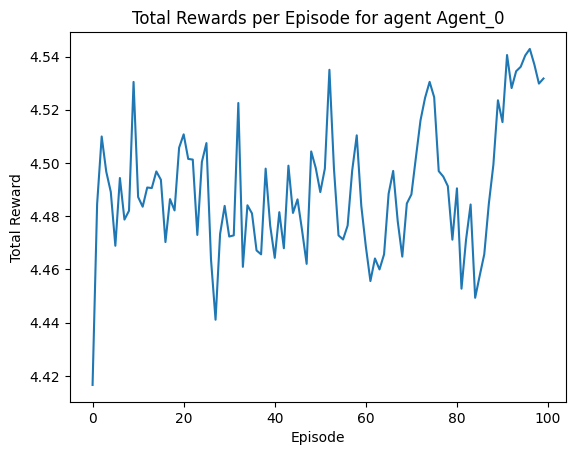

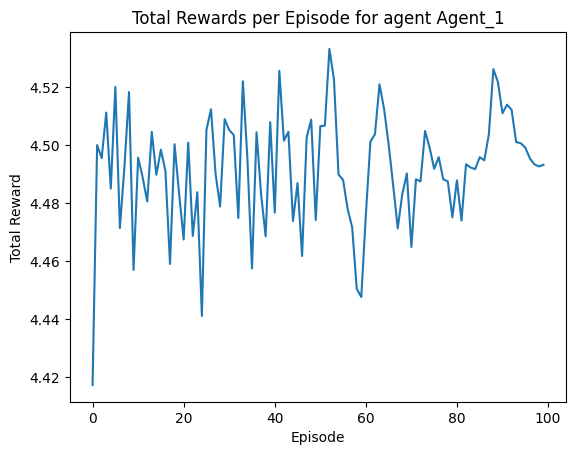

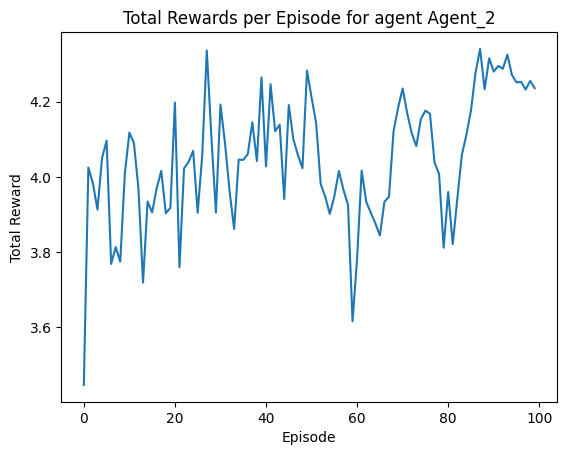

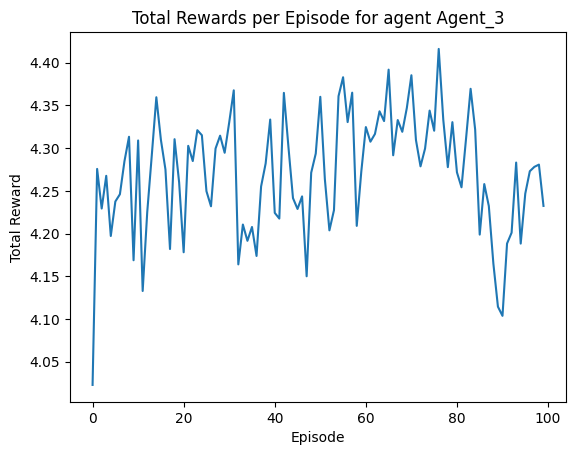

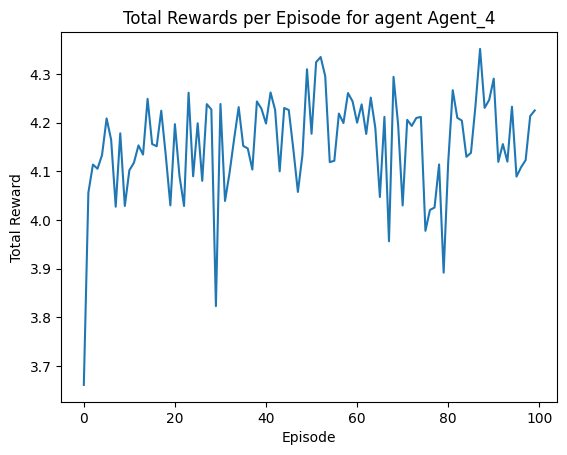

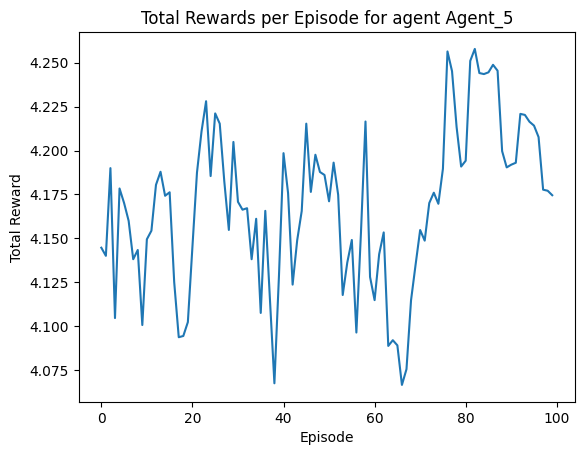

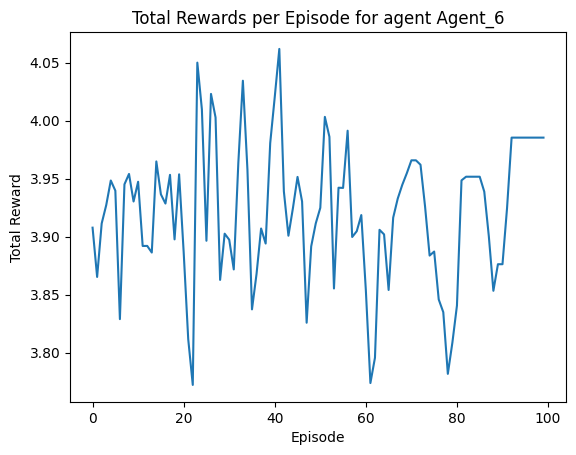

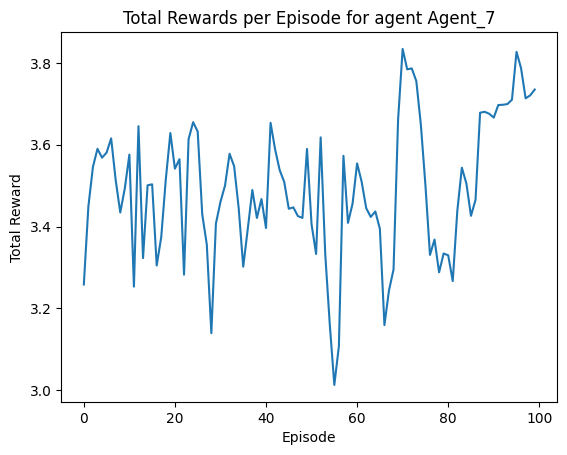

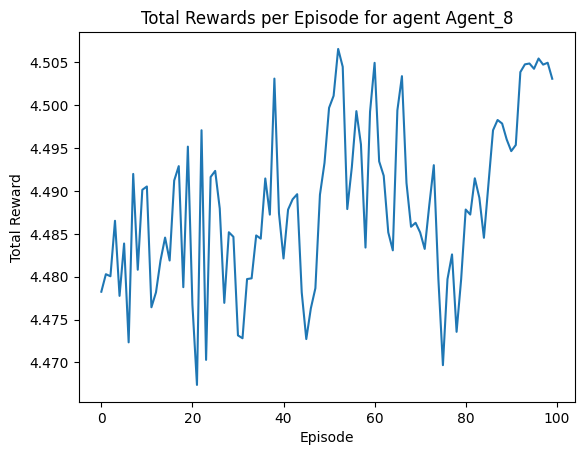

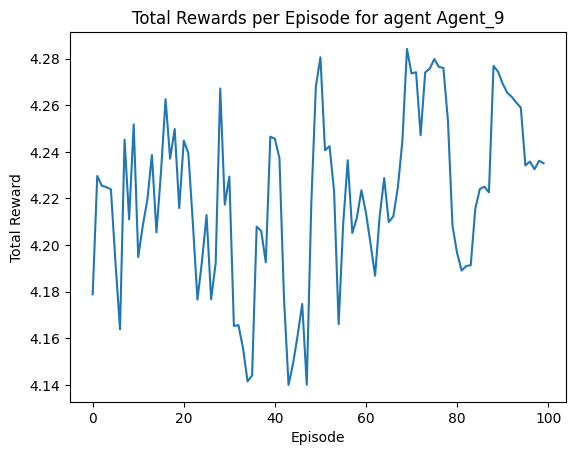

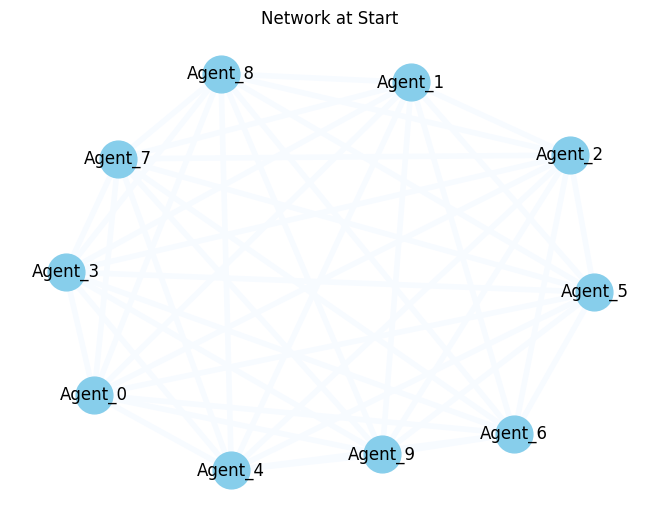

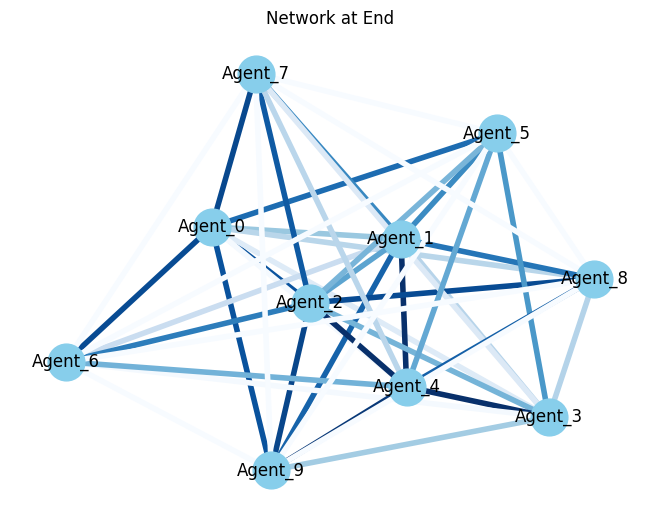

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
import pandas as pd
import torch.distributions as distributions
from tqdm import trange

# Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, learning_rate=0.01, gamma=0.90):
        super(PolicyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.gamma = gamma

    def forward(self, state):
        return self.model(state)

    def predict(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        return self.forward(state)

    def update(self, states, actions, rewards, next_states):
        self.optimizer.zero_grad()

        # Forward pass for current and next states
        current_q_values = self.forward(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.forward(next_states).max(1)[0].detach()

        # Compute expected Q values using the Bellman equation
        target_q_values = rewards + self.gamma * next_q_values  # discount factor gamma = 0.99

        # Calculate loss using mean squared error
        loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))

        # Backpropagation and optimization
        loss.backward()
        self.optimizer.step()

        # # return loss
        # self.optimizer.zero_grad()
        # probs = self.forward(states)
        # log_probs = torch.log(self.forward(states))
        # loss = -(log_probs*rewards).mean()
        # loss.backward()
        # self.optimizer.step()

        return loss


# Define the Agent
class Agent:
    def __init__(self, name, environment, epsilon=0.5):
        self.name = name
        self.social_network = environment
        self.state_dim = 3
        # self.action_dim = 2
        self.action_dim = 6 # considering that we have 5 Agents and we want one of the actions to just not interact at all.
        self.create_characteristics()
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim)
        self.epsilon = epsilon  # Exploration parameter
        self.reward_history = []  # To store the reward history for this agent
        self.well_being = 0

    def get_state(self):
        self.update_wellbeing()
        avg_connection_strength = self.total_weight / max(1, self.degree)
        state = [self.introversion, self.well_being, avg_connection_strength]
        return state

    # def select_partner(self):
    #     # Strategically select partner based on connection strength
    #     edges = list(self.social_network.network.edges(self.name, data=True))
    #     if not edges:
    #         return None  # In case there are no edges
    #     # Choose the partner with the strongest connection

    #     selected_edge = max(edges, key=lambda x: x[2]['weight'])
    #     return (selected_edge[0], selected_edge[1])


    # def select_partner(self):
    #   edges = list(self.social_network.network.edges(self.name, data=True))
    #   if not edges:
    #       return None  # In case there are no edges

    #   # Random selection weighted by connection strength
    #   total_weight = sum(data['weight'] for _, _, data in edges)
    #   if total_weight > 0:
    #       weights = [data['weight'] / total_weight for _, _, data in edges]
    #       selected_edge = random.choices(edges, weights=weights, k=1)[0]
    #   else:
    #       # If no weights are non-zero, select randomly
    #       selected_edge = random.choice(edges)

    #   return (selected_edge[0], selected_edge[1]) # Return the partner node

    # def select_partner(self):
    #   edges = list(self.social_network.network.edges(self.name))
    #   if not edges:
    #       return None
    #   return random.choice(edges)[0], random.choice(edges)[1]  # Randomly select an interaction partner


    def action(self):
      state = self.get_state()
      action_prob = self.policy_net.predict(state) # These are the probabilities for interaction with Agent i, no interaction 
    #   print(action_prob) # this is just to check whether we have the actual right action dimension

      # Choosing between exploration and exploitation
      if np.random.rand() < self.epsilon:
        action = np.random.choice(self.action_dim) # exploring what happens when you interact with an agent
      else:
      # Sampling an action from the probability distribution
        action_dist = distributions.Categorical(action_prob) # Look into this more deeply, change it potentially
        action = action_dist.sample().item() # this is taking one of the actions and performing it

      if action == 0: # this is for the case when there is no action at all. 
          pass
      else:
        # interaction_partner = self.select_partner()
        interaction_partner = f"Agent_{action-1}"
        if interaction_partner != self.name:
        # LLM will play in here in determining the quality of the conversation
          quality_conversation = random.uniform(0,1) # random quality conversation
          self.social_network.update_connection((self.name, interaction_partner), quality_conversation)

      old_state = state
      next_state = self.get_state()
      self.update_wellbeing()
      reward = self.well_being # Adding a little bit of gaussian noise here. # this is a place to be augmented as well

      self.reward_history.append(reward) # Storing the reward for this state

      return old_state, action, next_state, reward

    #   state = self.get_state()
    #   action_prob = self.policy_net.predict(state)

    #   # Exploration-exploitation strategy: ε-greedy
    #   if np.random.rand() < self.epsilon:
    #       action = np.random.choice(self.action_dim)
    #   else:
    #       # Sample action from the probability distribution
    #       action_dist = distributions.Categorical(action_prob)
    #       action = action_dist.sample().item()

    #   if action == 0:
    #       interaction_partner = self.select_partner()
    #       if interaction_partner:
    #           quality_conversation = random.uniform(0, 1)  # Random quality conversation
    #           self.social_network.update_connection(interaction_partner, quality_conversation)

    #   old_state = state
    #   next_state = self.get_state()
    #   reward = self.well_being
    #   self.reward_history.append(reward)  # Store the reward for this step
    #   return old_state, action, next_state, reward

    # def update_wellbeing(self):
    #     self.degree = 0
    #     self.total_weight = 0
    #     for u, v in self.social_network.network.edges(self.name):
    #         self.total_weight += self.social_network.network[u][v]['weight']
    #         if self.social_network.network[u][v]['weight'] != 0.0:
    #           self.degree += 1
    #     self.sociality = self.total_weight / max(1, self.degree)
    #     # self.sociality = 1/(1 + np.exp(-self.total_weight)) 

    #     # self.well_being = (1 - self.introversion) * self.sociality + self.introversion * self.degree
    #     x = np.linspace(-10, 10, 100) 
    #     self.well_being = ((self.introversion) * self.sociality + self.introversion * max(1,self.degree))* (1/(1+np.exp(-x)))

    def update_wellbeing(self):
      self.degree = self.social_network.network.degree(self.name)
      self.total_weight = sum(self.social_network.network[self.name][v]['weight'] for v in self.social_network.network[self.name])
      self.sociality = self.total_weight / max(1, self.degree)
      centrality = nx.closeness_centrality(self.social_network.network, self.name)
      self.well_being = (self.introversion * self.sociality) + ((1 - self.introversion) * centrality)

    
    def create_characteristics(self):
        self.introversion = random.uniform(0, 1)

# Define the Social Network
class SocialNetwork:
    def __init__(self, agents):
        self.participants = agents
        self.network = nx.Graph()
        self.history = []  # To store historical states of the network
        for src in self.participants:
            for dst in self.participants:
                if src != dst:
                    self.network.add_edge(src, dst, weight=0)

    def update_connection(self, connection, strength):
        src, dst = connection
        self.network[src][dst]['weight'] = strength
        self.log_change(src, dst, strength)

    def log_change(self, src, dst, weight):
        # Store the change in a log
        self.history.append((src, dst, weight))

    def snapshot(self):
        # Take a snapshot of the entire network
        return copy.deepcopy(self.network)

    def visualize(self):
        nt = Network(notebook=True)
        nt.from_nx(self.network)
        nt.show('network.html')

def visualize_network(network, title="Social Network"):
    pos = nx.spring_layout(network)
    weights = nx.get_edge_attributes(network, 'weight')
    nx.draw(network, pos, with_labels=True, node_size=700, node_color='skyblue',
            edge_color=[float(v) for v in weights.values()], width=4, edge_cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Setup function for agents and network
def setup(num_agents):
    agent_names = [f"Agent_{i}" for i in range(num_agents)]
    network = SocialNetwork(agent_names)
    agents = {name: Agent(name, network) for name in agent_names}
    return agents, network

snapshots = []
import copy

# Training function
def train(agents, network, num_episodes, max_steps_per_episode):
    rewards_history = {agent_name: [] for agent_name in agents.keys()}
    network_evolution = []
    decay = 0.955

    for episode in trange(num_episodes):
        episode_network = {}
        if episode % 10 == 0:
            snapshots.append(network.snapshot())

        for agent_name, agent in agents.items():
            total_reward = 0
            for step in range(max_steps_per_episode):
                old_state, action, next_state, reward = agent.action()
                agent.policy_net.update(torch.tensor([old_state], dtype=torch.float32),
                                         torch.tensor([action], dtype=torch.int64),
                                         torch.tensor([reward], dtype=torch.float32),
                                         torch.tensor([next_state], dtype=torch.float32))
                total_reward += reward
            rewards_history[agent_name].append(total_reward)
            episode_network[agent_name] = np.array(agent.get_state())
            agents[agent_name].epsilon *= decay

        network_evolution.append(episode_network)

    df_network_evolution = pd.DataFrame(network_evolution)

    for agent_name, rewards in rewards_history.items():
        plt.plot(np.log(rewards))
        plt.title(f'Total Rewards per Episode for agent {agent_name}')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

    visualize_network(snapshots[0], "Network at Start")
    visualize_network(snapshots[-1], "Network at End")
    return rewards_history

# Assuming we have 5 agents
agents, network = setup(10)
history_rewards = train(agents, network, 100, 100)